# Research model
This is the implementation of the model, which is used in the research. However, instead of "debt", I used "stock market". This is because "debt" does not accurately predict the stock market anymore. No change in search volume in the entire period of the corona-virus. "stock market" search volume always changes accordingly.

$$
\Delta n(t, \Delta t) = n(t) - N(t - 1, \Delta t)
$$

$$
N(t - 1, \Delta t) = \frac{n(t-1) + n(t-2) + \cdots + n(t-\Delta t)}{\Delta t}
$$

$$
buy\text{_}signal = \Delta n(t-1, \Delta t) < 0
$$

$$
sell\text{_}signal = \Delta n(t-1, \Delta t) > 0
$$

As can be seen, this implementation has a 23.9% annual return over 16.5 years. This period has seen two major crashes (2008 housing market, 2020 corona-virus). It accurately predicted both of these crashes. A $\Delta t$ of 3 was used.

This is the strategy used by the research in `../references/Quantifying-Trading-Behavior-in-Financial-Markets-Using-Google-Trends.pdf`.

In [1]:
import pandas as pd
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
trends = pd.read_csv("../data/raw/weekly/stock_market.csv")

In [3]:
djia = yf.download("DJIA", start="2004-01-01", interval="1wk")
djia = djia[1:861]

[*********************100%***********************]  1 of 1 completed


In [4]:
df = pd.DataFrame()

df["debt"] = trends.Adjusted
df["close"] = djia.reset_index().Close

df["pct_change"] = df.close.pct_change() + 1

In [5]:
df["N"] = df.debt.rolling(window=3).mean().shift(1)
df["n"] = df.debt - df.N

In [6]:
df["signal"] = ""

for i, data in enumerate(df.n):
    if data > 0:
        df.loc[i, "signal"] = 1
    else:
        df.loc[i, "signal"] = 0
        
df = df[3:]
df = df.reset_index()

In [7]:
i = 0
current_port = 100
current_bh = 100
correct = 0
df["portfolio"] = 0
df["buyhold"] = 0
buy_signals = []
sell_signals = []

while i < len(df):
    if df.signal[i] == 0:
        current_port *= df["pct_change"][i]
        buy_signals.append(i)
        if df["pct_change"][i] > 1:
            correct += 1
    else:
        current_port /= df["pct_change"][i]
        sell_signals.append(i)
        if df["pct_change"][i] < 1:
            correct += 1
        
    current_bh *= df["pct_change"][i]
    
    df.loc[i, "portfolio"] = current_port
    df.loc[i, "buyhold"] = current_bh
    
    i += 1

In [8]:
print("Accuracy:", round((correct / len(df)) * 100, 1), "%")
print("Total Return:", round((df["portfolio"][856] / 100) * 100, 1), "%")
print("Annualised Return:", round(((df["portfolio"][856] / 100) ** (1 / (len(df)/52)) - 1) * 100, 1), "%")

Accuracy: 56.2 %
Total Return: 3421.5 %
Annualised Return: 23.9 %


# Visualisation
Two visualisations:
1. Google Trends strategy vs. buy-and-hold strategy;
2. Stock price during 

<AxesSubplot:xlabel='index', ylabel='buyhold'>

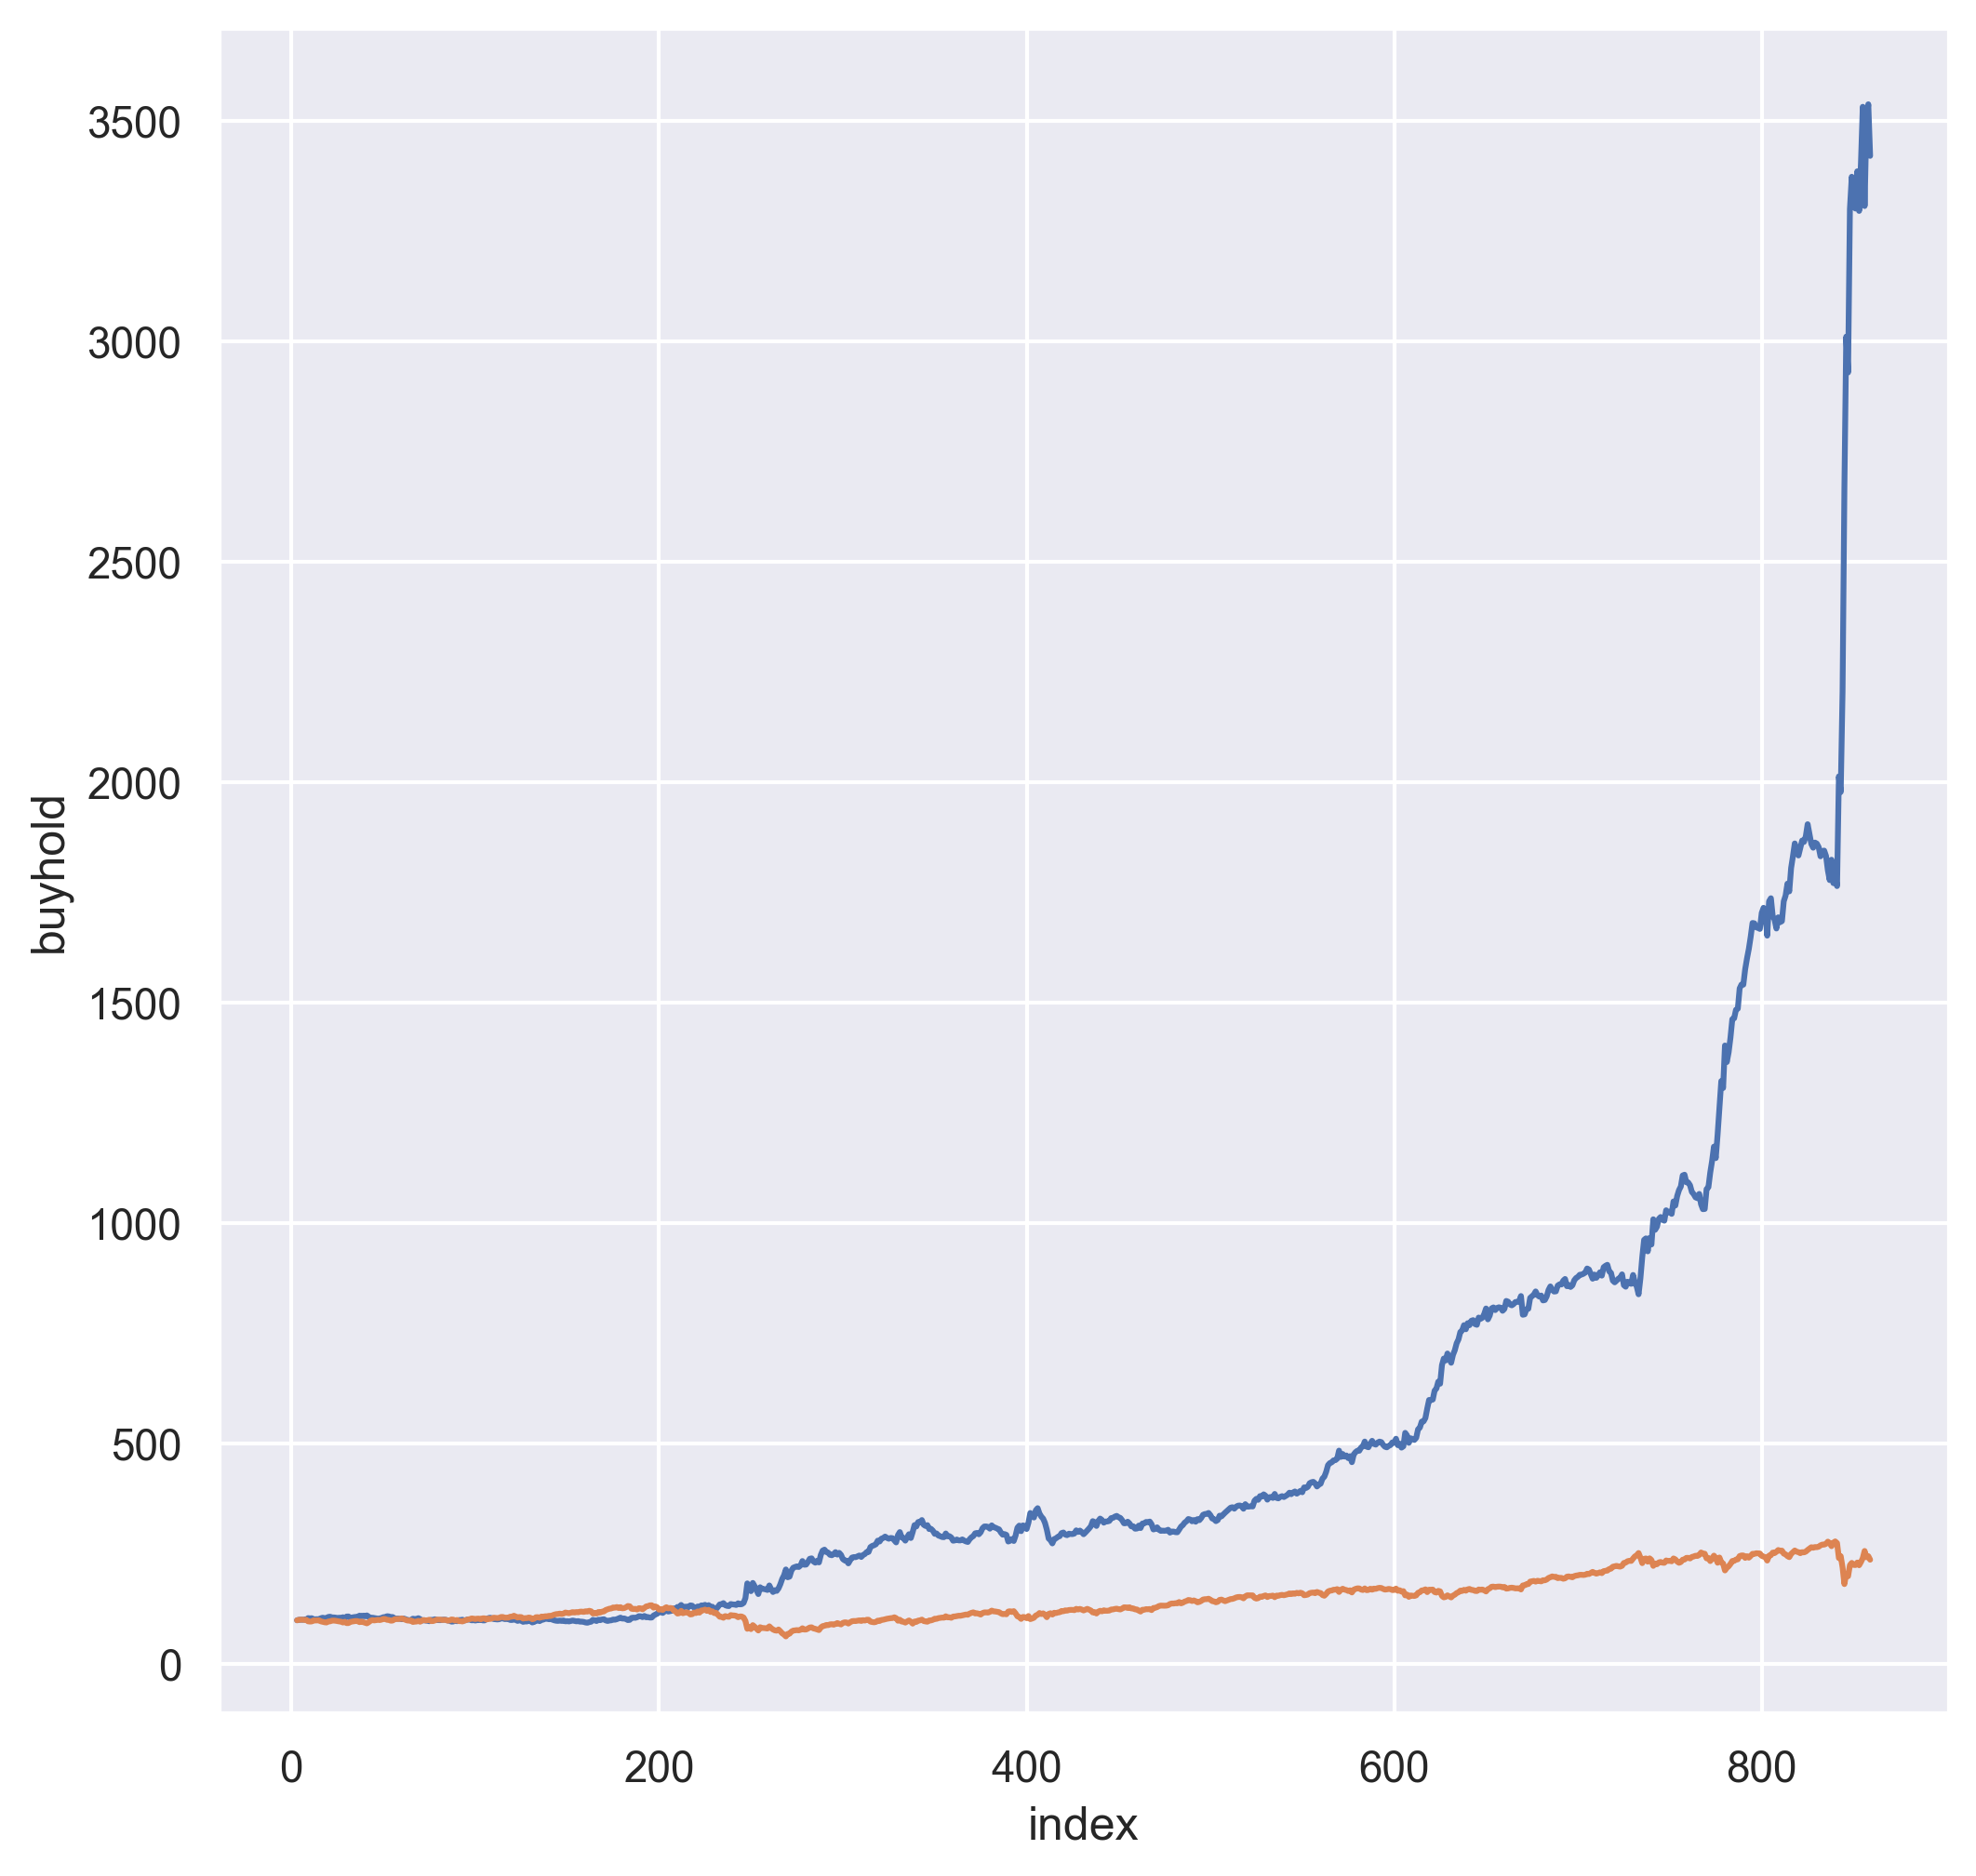

In [11]:
sns.set()

fig, ax = plt.subplots(1, 1, figsize=(8, 8), dpi=300)

sns.lineplot(x="index", y="portfolio", data=df, ax=ax)
sns.lineplot(x="index", y="buyhold", data=df, ax=ax)

<AxesSubplot:xlabel='index', ylabel='close'>

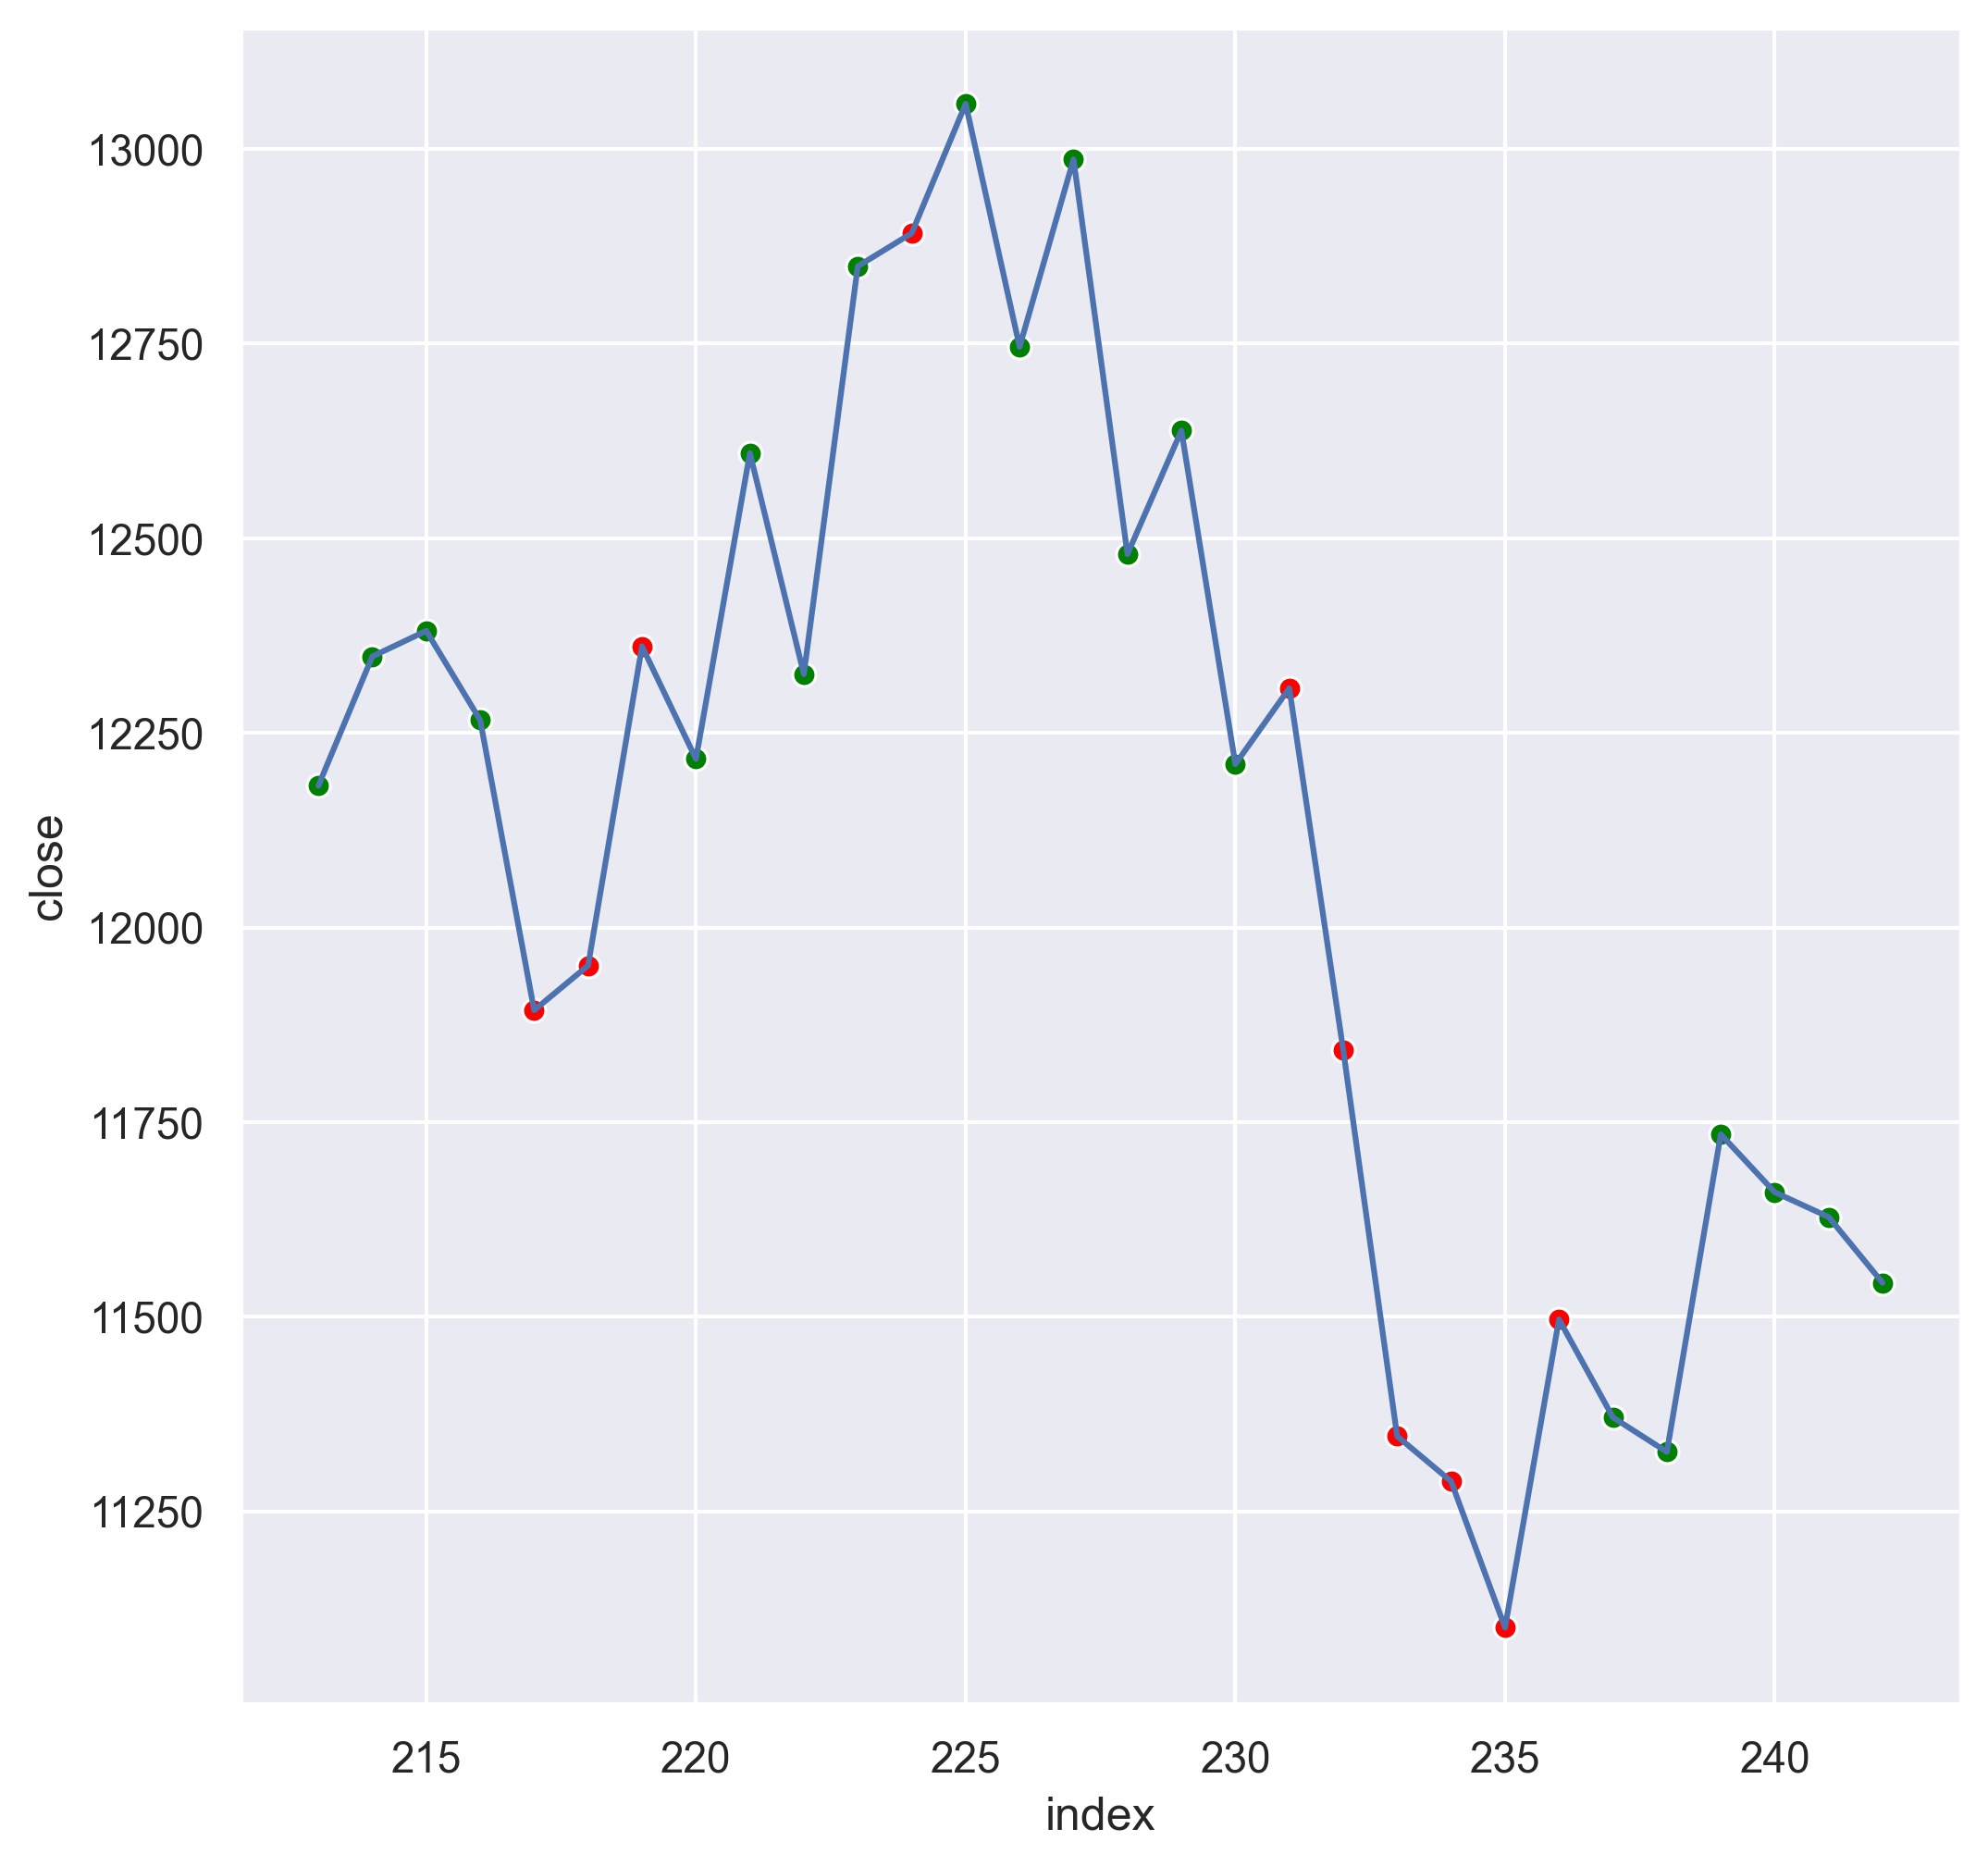

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8), dpi=300)

sns.lineplot(x=df["index"][210:240], y=df["close"], ax=ax)
sns.scatterplot(x=df["index"][210:240], y=df["close"][buy_signals], ax=ax, color="green")
sns.scatterplot(x=df["index"][210:240], y=df["close"][sell_signals], ax=ax, color="red")